
# LAB2: Анализ дифференциальной экспрессии

# Использование DESeq2

## Подготовительные действия

Установим "DESeq2" и загрузим необходимые библиотеки.

In [1]:
options(warn = -1)
suppressMessages(BiocManager::install("DESeq2"))

In [2]:
suppressMessages(library(DESeq2))

Считаем и предобработаем данные.

In [3]:
sample_name <- 'E-GEOD-78936.sdrf.txt'
counts_name <- 'E-GEOD-78936-raw-counts.tsv'

In [4]:
smpls <- read.table(sample_name, sep = "\t", header = T)
counts <- read.table(counts_name, sep = '\t', header = T, row.names = 1)[, -1]

# возьмем только важные нам столбцы
smpls <- unique(smpls[, c("Scan.Name", "FactorValue..organism.part.", "FactorValue..disease.")])
colnames(smpls) <- c("Scan", "Brain_area", "Disease")
rownames(smpls) <- smpls$Scan
smpls$Scan <- NULL

# поскольку строки в smpls уже отсортированы, отсортируем столбцы в counts
# чтобы номер столбца был равен номеру строки в smpls

counts <- counts[, order(names(counts))]

Raw counts:

In [5]:
head(counts)

,SRR3206740,SRR3206741,SRR3206742,SRR3206743,SRR3206744,SRR3206745,SRR3206746,SRR3206747,SRR3206748,SRR3206749,...,SRR3206812,SRR3206813,SRR3206814,SRR3206815,SRR3206816,SRR3206817,SRR3206818,SRR3206819,SRR3206820,SRR3206821
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,7,21,4,27,18,12,17,29,23,30,...,25,53,15,15,43,30,22,28,29,24
ENSG00000000005,0,1,0,1,3,0,0,0,0,2,...,2,3,0,0,0,0,0,0,0,0
ENSG00000000419,46,69,14,56,22,64,38,29,59,62,...,62,83,39,62,31,30,36,38,22,27
ENSG00000000457,19,23,1,29,15,27,17,17,21,23,...,32,42,24,36,14,19,14,25,19,12
ENSG00000000460,1,6,1,2,7,2,0,0,4,6,...,9,7,3,6,3,5,2,7,2,5
ENSG00000000938,10,5,24,10,15,3,0,14,13,11,...,22,7,19,11,22,24,17,30,12,8


Gene samples data:

In [6]:
head(smpls)

,Brain_area,Disease
,<chr>,<chr>
SRR3206740,Brodmann (1909) area 11,bipolar disorder
SRR3206741,Brodmann (1909) area 11,bipolar disorder
SRR3206742,Brodmann (1909) area 11,bipolar disorder
SRR3206743,Brodmann (1909) area 11,bipolar disorder
SRR3206744,Brodmann (1909) area 11,bipolar disorder
SRR3206745,Brodmann (1909) area 11,bipolar disorder


## DESeq2 usage

Итак, поскольку наши данные имеют два столбца полезных метаданных - это область мозга, для которой проводились исследования (BA9/BA11/BA24), а также само значение заболевания (шизофрения/биполярное расстройство/здоровый человек), параметр `design` будет особым. Будем тестировать влияние на "заболевание" такого фактора как "область мозга".

In [7]:
des_obj <- suppressMessages(DESeqDataSetFromMatrix(countData = counts,
                                   colData = smpls,
                                   design = ~Brain_area + Disease))

Для наглядности нарисуем данные в PCA (это, правда, ничего полезного не дает, но я попытался).

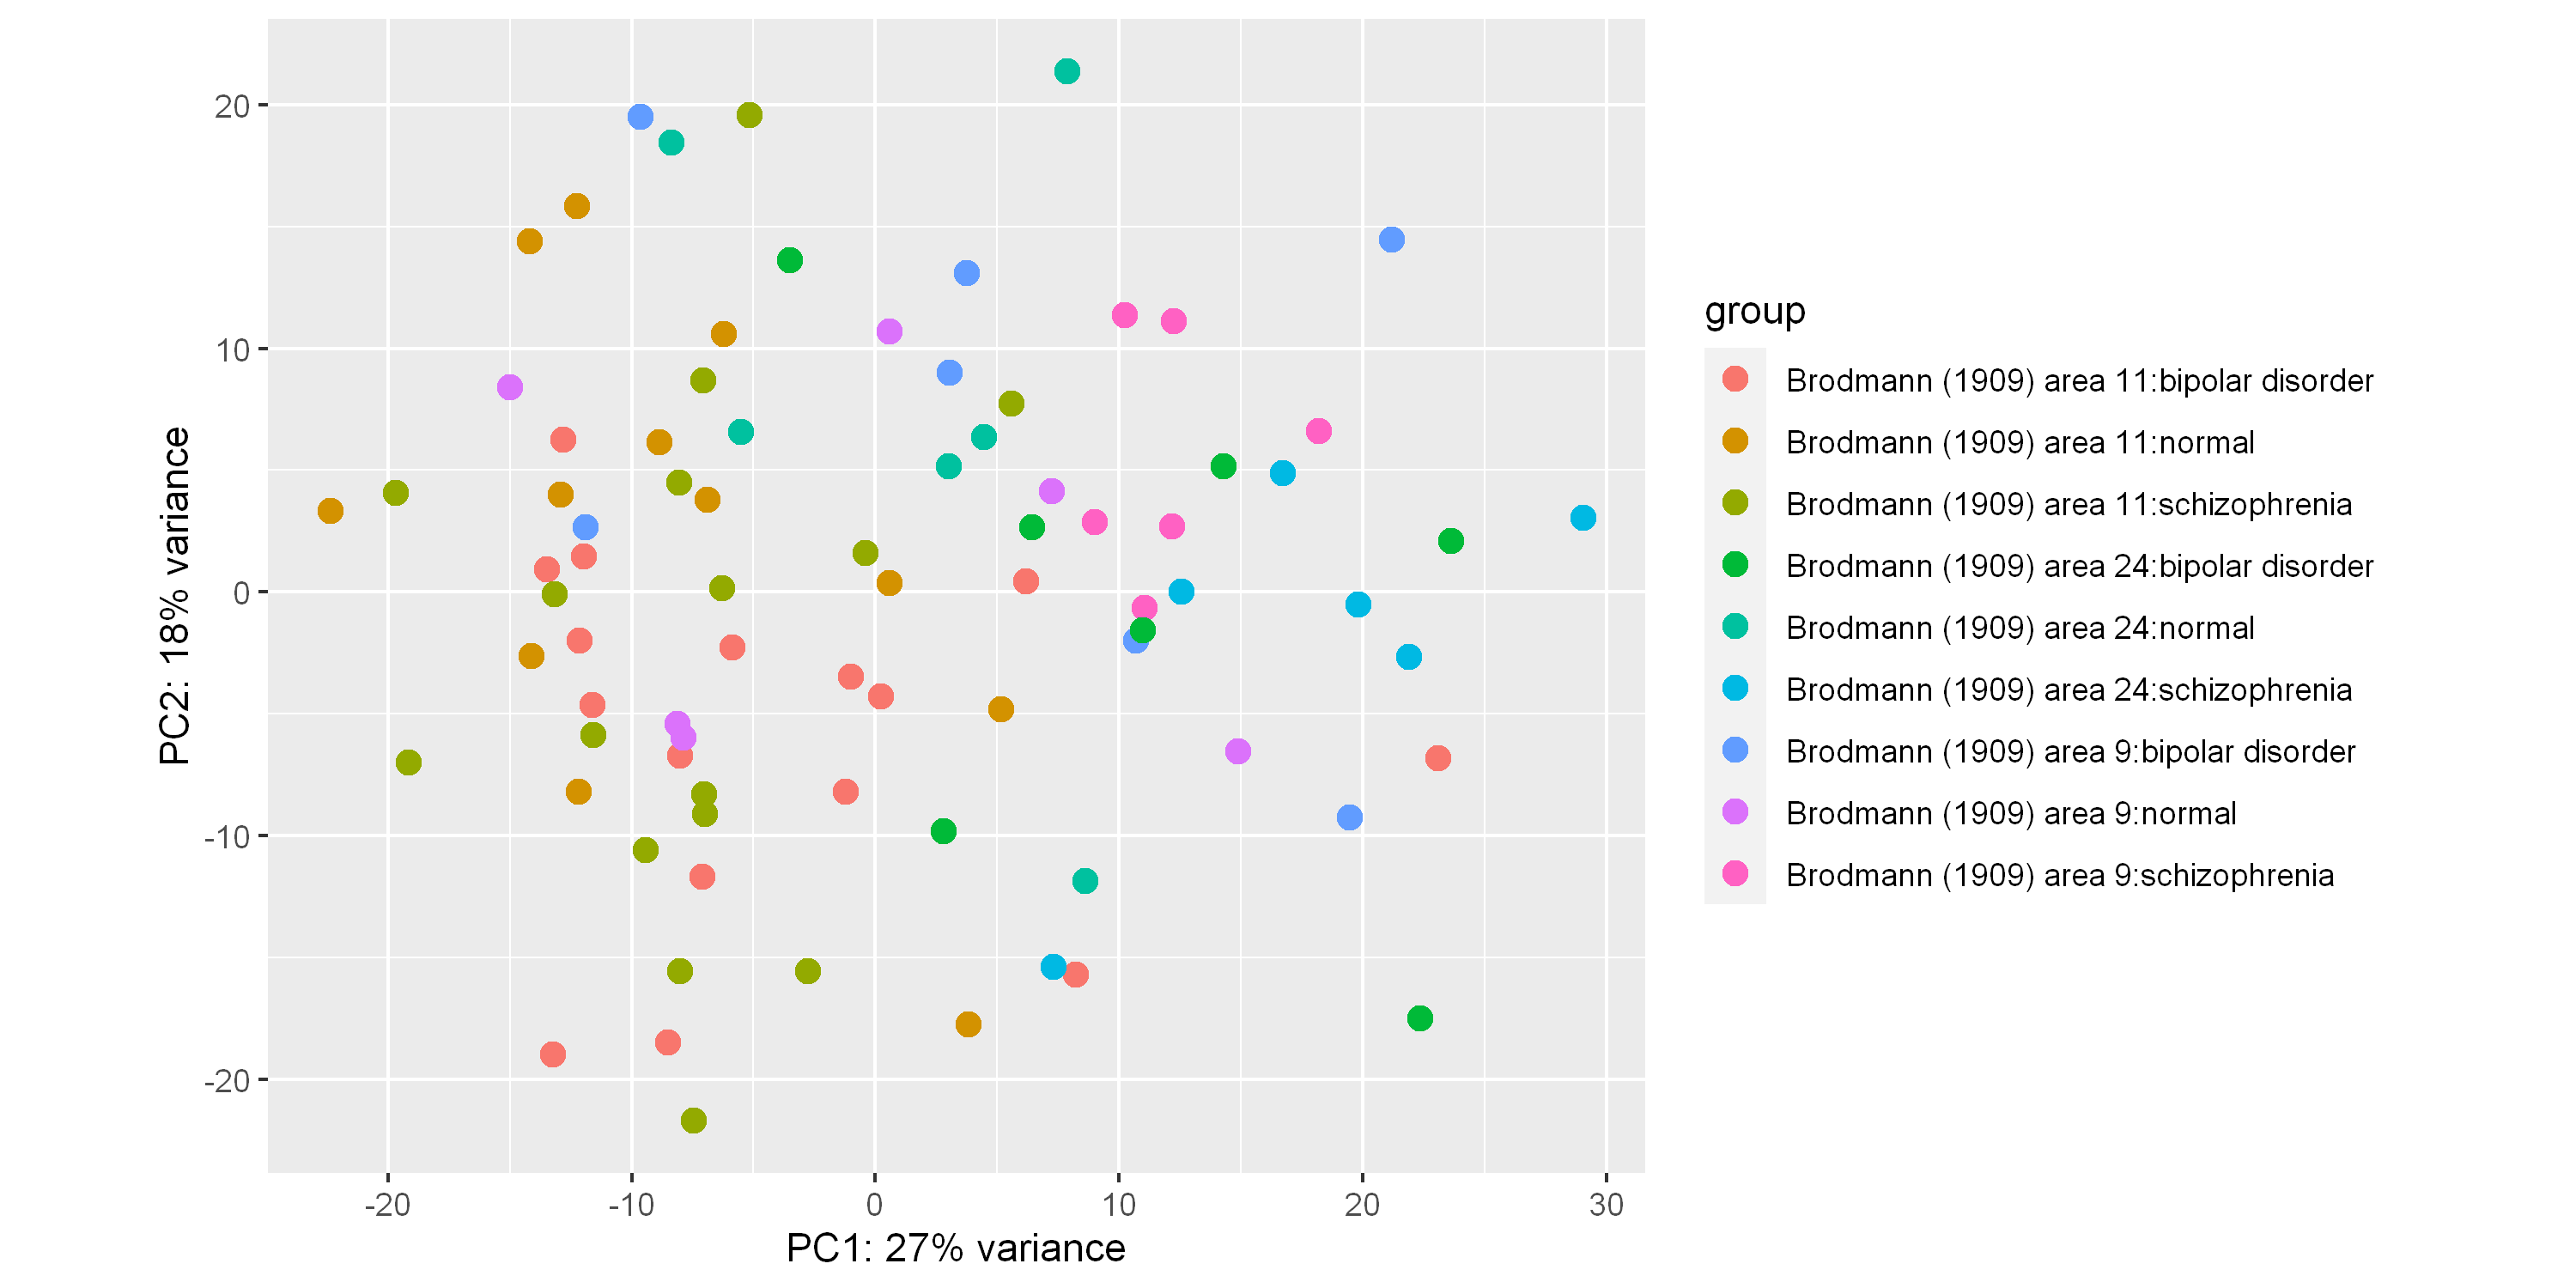

In [8]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res = 300)
# blind = TRUE because of 
# comparing samples in an manner unbiased by prior information on samples
vstdata <- vst(des_obj, blind = T)
plotPCA(vstdata, intgroup = c("Brain_area", "Disease"))

Теперь проведем сам анализ. Он происходит поэтапно:  
- estimating size factors
- estimating dispersions
- gene-wise dispersion estimates
- mean-dispersion relationship
- final dispersion estimates
- fitting model and testing

In [10]:
DES <- suppressMessages(DESeq(des_obj))
DES

class: DESeqDataSet 
dim: 58735 82 
metadata(1): version
assays(6): counts mu ... replaceCounts replaceCooks
rownames(58735): ENSG00000000003 ENSG00000000005 ... ENSG00000285993
  ENSG00000285994
rowData names(35): baseMean baseVar ... maxCooks replace
colnames(82): SRR3206740 SRR3206741 ... SRR3206820 SRR3206821
colData names(4): Brain_area Disease sizeFactor replaceable

Посмотрим, какие результаты получились:

In [11]:
resultsNames(DES)

[1] "Intercept"                                                    
[2] "Brain_area_Brodmann..1909..area.24_vs_Brodmann..1909..area.11"
[3] "Brain_area_Brodmann..1909..area.9_vs_Brodmann..1909..area.11" 
[4] "Disease_normal_vs_bipolar.disorder"                           
[5] "Disease_schizophrenia_vs_bipolar.disorder"

Выберем шизофрению и биполярное расстройство.

In [12]:
res <- results(DES, name = "Disease_schizophrenia_vs_bipolar.disorder", alpha = 0.05)
res

log2 fold change (MLE): Disease schizophrenia vs bipolar.disorder 
Wald test p-value: Disease schizophrenia vs bipolar.disorder 
DataFrame with 58735 rows and 6 columns
                 baseMean log2FoldChange     lfcSE        stat    pvalue
                <numeric>      <numeric> <numeric>   <numeric> <numeric>
ENSG00000000003 20.188784   -0.018986774  0.153263 -0.12388341  0.901408
ENSG00000000005  0.399063   -0.812156025  0.843366 -0.96299305  0.335551
ENSG00000000419 45.608842   -0.089971093  0.124552 -0.72235928  0.470074
ENSG00000000457 22.157197    0.111351502  0.109060  1.02101116  0.307249
ENSG00000000460  3.760020   -0.000720035  0.259048 -0.00277954  0.997782
...                   ...            ...       ...         ...       ...
ENSG00000285990 0.0107683     -0.0300479  3.476204 -0.00864389  0.993103
ENSG00000285991 3.7600243     -0.2720523  0.259544 -1.04819238  0.294550
ENSG00000285992 0.0000000             NA        NA          NA        NA
ENSG00000285993 0.0609192   

Видим, что в таблице получились `NA`. Гены в `DESeq2` автоматически фильтруются "независимой фильтрацией". Гены, которые получили значение `NA` метод автоматически отфильтровал.  
"Независимая фильтрация" представляет собой оптимизацию количества скорректированных значений p-value ниже указанного уровня значимости.  
Уровень значимости по умолчанию для независимой фильтрации = `0.1`, но мы задали его насильно равным `0.05`, как указано в статье для этого кейса.

Теперь отфильтруем полученные данные все по тому же порогу `padj < 0.05`.  
Удовлетворяющие этому условию гены будут считаться дифференциально экспрессирующимися.

In [13]:
res <- res[complete.cases(res), ]
res <- res[res[, "padj"] < 0.05, ]
res

log2 fold change (MLE): Disease schizophrenia vs bipolar.disorder 
Wald test p-value: Disease schizophrenia vs bipolar.disorder 
DataFrame with 1 row and 6 columns
                 baseMean log2FoldChange     lfcSE      stat      pvalue
                <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000262902   48.9828       -3.48245  0.559036  -6.22939 4.68261e-10
                       padj
                  <numeric>
ENSG00000262902 2.05318e-05

Подходящий под наше условие ген всего один. Можем считать, что анамнез людей, болеющих шизофренией и биполярным расстройством схож. Поэтому рассмотрим тогда случай здоровых пациентов VS больных биполярным расстройством. 

In [14]:
res <- results(DES, name = "Disease_normal_vs_bipolar.disorder", alpha = 0.05)
res <- res[complete.cases(res), ]
background <- res
res <- res[res[, "padj"] < 0.05, ]
res <- res[order(res$padj), ]
res

log2 fold change (MLE): Disease normal vs bipolar.disorder 
Wald test p-value: Disease normal vs bipolar.disorder 
DataFrame with 564 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat      pvalue
                <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000255823   28.2630       -5.01106  0.730558  -6.85922 6.92351e-12
ENSG00000187193   51.0694       -2.20647  0.378216  -5.83390 5.41478e-09
ENSG00000262902   48.9828       -3.38750  0.581318  -5.82728 5.63369e-09
ENSG00000237973  393.3385       -1.55862  0.290039  -5.37383 7.70808e-08
ENSG00000169715  183.5905       -1.26831  0.241224  -5.25782 1.45772e-07
...                   ...            ...       ...       ...         ...
ENSG00000147862  431.1041      -0.345581 0.1118464  -3.08978  0.00200305
ENSG00000135454  168.6610       0.334071 0.1081560   3.08879  0.00200974
ENSG00000125977  240.2973      -0.352862 0.1143572  -3.08561  0.00203134
ENSG00000137996   73.2166       0.232965 0.0

Теперь получили достаточно интересный результат - целых 564 дифференциально экспрессирующихся гена! Эти гены, как мы будем считать, будут показывать разницу между двумя группами (здоровых и больных людей).  
Выведем названия некоторых из них:

In [15]:
# самая большая библиотека согласно 
# https://shiring.github.io/genome/2016/10/23/AnnotationDbi
suppressMessages(library(EnsDb.Hsapiens.v79))

In [16]:
# для двух генов имена не нашлись :(
gene_names <- ensembldb::select(EnsDb.Hsapiens.v79, 
                                     keys = rownames(res),
                                     keytype = "GENEID", columns = c("GENEID","SYMBOL"))
head(gene_names, 30)

,GENEID,SYMBOL
,<chr>,<chr>
1,ENSG00000255823,MTRNR2L8
2,ENSG00000187193,MT1X
3,ENSG00000262902,RP11-750B16.1
4,ENSG00000237973,RP5-857K21.6
5,ENSG00000169715,MT1E
6,ENSG00000198417,MT1F
7,ENSG00000125144,MT1G
8,ENSG00000125148,MT2A
9,ENSG00000108848,LUC7L3


Для анализа в DAVID сохраним данные в файлы.

In [38]:
write(rownames(res), file = 'gene_names.txt')
write(rownames(background), file = "background.txt")

## Обработка данных после DAVID

__Note:__ Для получения данных KEGG выбиралась лишь `KEGG_PATHWAY`. Для получения данных GO выбирались три предложенные (подсвеченные красным) опции: `GOTERM_BP_DIRECT`, `GOTERM_CC_DIRECT`, `GOTERM_MF_DIRECT`.

In [17]:
GO_data <- read.table("GO_data.txt", sep = "\t", header = T)
KEGG_data <- read.delim('KEGG_data.txt', header = TRUE, sep = "\t", dec = ".")

DAVID также использует поправку на множественное тестирование (аналогично "независимой фильтрации"). Поэтому воспользуемся отсечением по параметру `FDR` по порогу, указанному в статье: `FDR < 0.05`.

#### GO results

In [18]:
GO_best <- GO_data[GO_data$FDR < 0.05, c("Category", "Term", "FDR")]
GO_best <- GO_best[order(GO_best$FDR), ]
GO_best

,Category,Term,FDR
,<chr>,<chr>,<dbl>
1,GOTERM_BP_DIRECT,GO:0006614~SRP-dependent cotranslational protein targeting to membrane,1.486120e-20
2,GOTERM_BP_DIRECT,"GO:0000184~nuclear-transcribed mRNA catabolic process, nonsense-mediated decay",2.556487e-19
3,GOTERM_BP_DIRECT,GO:0006413~translational initiation,1.324775e-18
4,GOTERM_BP_DIRECT,GO:0019083~viral transcription,2.653548e-17
5,GOTERM_MF_DIRECT,GO:0044822~poly(A) RNA binding,2.333083e-15
6,GOTERM_MF_DIRECT,GO:0003735~structural constituent of ribosome,2.097143e-13
7,GOTERM_CC_DIRECT,GO:0005840~ribosome,3.814434e-13
8,GOTERM_BP_DIRECT,GO:0006364~rRNA processing,7.102159e-13
9,GOTERM_BP_DIRECT,GO:0006412~translation,5.930576e-12


#### KEGG results

In [19]:
KEGG_data <- KEGG_data[order(KEGG_data$FDR), c("Category", "Term", "FDR")]
KEGG_data

,Category,Term,FDR
,<chr>,<chr>,<dbl>
1,KEGG_PATHWAY,hsa03010:Ribosome,1.466400e-16
2,KEGG_PATHWAY,hsa00190:Oxidative phosphorylation,4.367678e-01
3,KEGG_PATHWAY,hsa04978:Mineral absorption,5.180254e-01
4,KEGG_PATHWAY,hsa03040:Spliceosome,9.305647e-01
5,KEGG_PATHWAY,hsa05012:Parkinson's disease,1.000000e+00
6,KEGG_PATHWAY,hsa03060:Protein export,1.000000e+00


In [20]:
KEGG_best <- KEGG_data[KEGG_data$FDR < 0.05, ]
KEGG_best

,Category,Term,FDR
,<chr>,<chr>,<dbl>
1,KEGG_PATHWAY,hsa03010:Ribosome,1.4664e-16


# FGSEA-анализ обогащенности

## Подготовительные действия

In [24]:
suppressMessages(BiocManager::install("fgsea"))

package 'fgsea' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Олекек\AppData\Local\Temp\Rtmpycu11V\downloaded_packages


In [21]:
library('fgsea')

Соберем более полный датасет - добавим названия генов в формате HGNC и Entrez Gene ID. Здесь уже воспользуемся другой библиотекой, которая содержит в себе больше именно `entrez` значений, все так же согласно [этому](https://shiring.github.io/genome/2016/10/23/AnnotationDbi) источнику.

In [23]:
library("AnnotationDbi")
library("org.Hs.eg.db")

res$symbol = suppressMessages(mapIds(org.Hs.eg.db,
                     keys=row.names(res), 
                     column="SYMBOL",
                     keytype="ENSEMBL",
                     multiVals="first"))

res$entrez = suppressMessages(mapIds(org.Hs.eg.db,
                     keys=row.names(res), 
                     column="ENTREZID",
                     keytype="ENSEMBL",
                     multiVals="first"))

res <- res[!is.na(res$entrez), ]
res

log2 fold change (MLE): Disease normal vs bipolar.disorder 
Wald test p-value: Disease normal vs bipolar.disorder 
DataFrame with 531 rows and 8 columns
                 baseMean log2FoldChange     lfcSE      stat      pvalue
                <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000255823   28.2630       -5.01106  0.730558  -6.85922 6.92351e-12
ENSG00000187193   51.0694       -2.20647  0.378216  -5.83390 5.41478e-09
ENSG00000262902   48.9828       -3.38750  0.581318  -5.82728 5.63369e-09
ENSG00000237973  393.3385       -1.55862  0.290039  -5.37383 7.70808e-08
ENSG00000169715  183.5905       -1.26831  0.241224  -5.25782 1.45772e-07
...                   ...            ...       ...       ...         ...
ENSG00000147862  431.1041      -0.345581 0.1118464  -3.08978  0.00200305
ENSG00000135454  168.6610       0.334071 0.1081560   3.08879  0.00200974
ENSG00000125977  240.2973      -0.352862 0.1143572  -3.08561  0.00203134
ENSG00000137996   73.2166       0.232965 0.0

Загрузим также датасеты, которые нам понадобятся: pathways для KEGG и GO.

In [20]:
suppressMessages(BiocManager::install("gageData"))

In [24]:
library(gageData)
data(kegg.sets.hs)
data(go.sets.hs)

## fgsea usage

Для того, чтобы использовать одноименную функцию `fgsea`, необходимо составить таблицу с ранжированными генами (где их названия будут уже в формате `entrez`). Каждому гену сопоставляется среднее по столбцу `res$stat`, если встречались одинаковые гены (в нашем случае это не так), а затем сортируется в порядке возрастания.

In [25]:
ranks <- aggregate(stat~entrez, data = res, FUN = 'mean')
ranks <- ranks[order(ranks$stat), ]

# conversion to named vector
ranks <- setNames(res$stat, res$entrez)
head(ranks)

100463486      4501 107075172 107075141      4493      4494 
-6.859225 -5.833896 -5.827283 -5.373832 -5.257821 -5.239041

### KEGG analysis

In [26]:
KEGG_res <- fgsea(pathway = kegg.sets.hs, stats = ranks, 
                  scoreType = "pos", 
                  nperm = 3000)

In [27]:
KEGG_res <- KEGG_res[KEGG_res$padj < 0.05, ]
KEGG_res <- KEGG_res[order(KEGG_res$padj), ]
KEGG_res

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
hsa01100 Metabolic pathways,0.0009996668,0.03523825,0.3093807,3.618189,2,32,"5315 , 9114 , 10554 , 2026 , 211 , 9791 , 2805 , 3098 , 80146 , 254531, 4191 , 4705 , 537 , 8703 , 1431 , 2583 , 3030 , 56898"
hsa05412 Arrhythmogenic right ventricular cardiomyopathy (ARVC),0.0006664445,0.03523825,0.9034091,3.001485,1,3,"782 , 10368, 488"
hsa00564 Glycerophospholipid metabolism,0.0009996668,0.03523825,0.8806818,2.925976,2,3,"10554 , 9791 , 254531"
hsa05410 Hypertrophic cardiomyopathy (HCM),0.0006664445,0.03523825,0.9034091,3.001485,1,3,"782 , 10368, 488"


### GO analysis

In [30]:
GO_res <- fgsea(pathway = go.sets.hs, stats = ranks, 
                  scoreType = "pos", 
                  nperm = 10000)

In [31]:
GO_res <- GO_res[GO_res$padj < 0.05, ]
GO_res <- GO_res[order(GO_res$padj), ]
GO_res

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
GO:0007268 synaptic transmission,9.999e-05,0.03276815,0.5173240,4.253207,0,18,"2030 , 7433 , 2567 , 10368, 9228 , 4885 , 351 , 6855 , 3754 , 627 , 1325 , 8775 , 2119 , 8411"
GO:0019226 transmission of nerve impulse,9.999e-05,0.03276815,0.5173240,4.253207,0,18,"2030 , 7433 , 2567 , 10368, 9228 , 4885 , 351 , 6855 , 3754 , 627 , 1325 , 8775 , 2119 , 8411"
GO:0035637 multicellular organismal signaling,9.999e-05,0.03276815,0.5173240,4.253207,0,18,"2030 , 7433 , 2567 , 10368, 9228 , 4885 , 351 , 6855 , 3754 , 627 , 1325 , 8775 , 2119 , 8411"
GO:0044710 single-organism metabolic process,9.999e-05,0.03276815,0.2081513,4.055953,0,87,"196463, 379 , 128486, 56603 , 5315 , 5306 , 10554 , 2026 , 7070 , 211 , 3376 , 4929 , 9791 , 2805 , 3098 , 51400 , 488 , 80146 , 81565 , 5660 , 254531, 4191 , 9435 , 351 , 2274 , 4705 , 8703 , 627 , 291 , 10197 , 10999 , 377 , 25830 , 1431 , 2583 , 3030 , 4504 , 56898"
GO:0055085 transmembrane transport,9.999e-05,0.03276815,0.6229814,4.973285,0,17,"2030 , 9114 , 9673 , 2567 , 10368 , 6574 , 3098 , 488 , 148808, 7781 , 537 , 10999 , 11261 , 206358"
GO:0012505 endomembrane system,9.999e-05,0.03276815,0.2735325,4.333796,0,59,"55176 , 128486, 56603 , 9114 , 10554 , 90523 , 26031 , 84937 , 10368 , 9158 , 9791 , 488 , 80146 , 81565 , 6734 , 254531, 9435 , 351 , 7781 , 112936, 6252 , 6855 , 8703 , 55638 , 10999 , 11261 , 377 , 2583"
GO:0016020 membrane,9.999e-05,0.03276815,0.2301382,5.829337,0,151,"2030 , 7433 , 379 , 55176 , 128486, 56603 , 5315 , 55054 , 9143 , 9114 , 3852 , 9673 , 10554 , 79137 , 2026 , 2567 , 7070 , 26031 , 8941 , 782 , 84937 , 10368 , 9158 , 6574 , 9791 , 654429, 3098 , 488 , 80146 , 5660 , 10540 , 6734 , 64101 , 9228 , 254531, 4191 , 9435 , 148808, 351 , 7781 , 4185 , 4705 , 8851 , 112936, 6252 , 537 , 6855 , 8703 , 130733, 3754 , 291 , 55638 , 10999 , 79102 , 11261 , 377 , 8775 , 206358, 2583"
GO:0016021 integral to membrane,9.999e-05,0.03276815,0.2560690,4.961501,0,86,"2030 , 7433 , 55176 , 128486, 9143 , 9673 , 10554 , 79137 , 2567 , 7070 , 782 , 10368 , 6574 , 9791 , 654429, 488 , 80146 , 5660 , 6734 , 64101 , 254531, 9435 , 148808, 351 , 7781 , 4185 , 6252 , 537 , 6855 , 8703 , 130733, 3754 , 291 , 55638 , 10999 , 79102 , 206358, 2583"
GO:0016324 apical plasma membrane,9.999e-05,0.03276815,0.9450758,3.123176,0,3,"2030, 9114, 7070"


# Сравнение полученных результатов

## DAVID (ORA) VS fgsea (GSEA)

KEGG:

In [32]:
KEGG_DAVID <- substring(KEGG_best$Term, 1, 8)
KEGG_fgsea <- substring(KEGG_res$pathway, 1, 8)

KEGG_res[KEGG_fgsea %in% KEGG_DAVID, 1]

pathway
<chr>


GO:

In [33]:
GO_DAVID <- substring(GO_best$Term, 1, 10)
GO_fgsea <- substring(GO_res$pathway, 1, 10)

GO_res[GO_fgsea %in% GO_DAVID, 1]

pathway
<chr>


Для KEGG и GO не совпал ни один результат. Поэтому попробуем расширить область поиска:
1. Для результатов GO в DAVID выберем все опции, а не только подсвеченные красным (предложенные), а затем просто проведем фильтрацию дублирующихся.
2. Используем порог по `padj`, приведенный в статье для `fgsea`: `padj < 0.25`.

### Пересчет DAVID GO:

In [34]:
GO_data_2 <- read.table("GO_data_2.txt", sep = "\t", header = T)

In [35]:
# удаляем дубликаты по именам, оставляя минимальный FDR
GO_data_2 <- GO_data_2[with(GO_data_2, ave(FDR, Term, FUN = min) == FDR), ]
GO_best_2 <- GO_data_2[GO_data_2$FDR < 0.05, c("Category", "Term", "FDR")]
GO_best_2 <- GO_best_2[order(GO_best_2$FDR), ]
head(GO_best_2)

,Category,Term,FDR
,<chr>,<chr>,<dbl>
1,GOTERM_BP_DIRECT,GO:0006614~SRP-dependent cotranslational protein targeting to membrane,1.486120e-20
4,GOTERM_BP_ALL,GO:0045047~protein targeting to ER,3.365411e-20
5,GOTERM_BP_ALL,GO:0006613~cotranslational protein targeting to membrane,3.365411e-20
8,GOTERM_BP_ALL,GO:0072599~establishment of protein localization to endoplasmic reticulum,1.151998e-19
11,GOTERM_BP_DIRECT,"GO:0000184~nuclear-transcribed mRNA catabolic process, nonsense-mediated decay",2.556487e-19
14,GOTERM_BP_DIRECT,GO:0006413~translational initiation,1.324775e-18


### Пересчет результатов fgsea

KEGG:

In [46]:
KEGG_res_new <- fgsea(pathway = kegg.sets.hs, stats = ranks, 
                  scoreType = "pos", 
                  nperm = 1000)

In [47]:
KEGG_res_new <- KEGG_res_new[order(KEGG_res_new$padj), ]
KEGG_res_new <- KEGG_res_new[KEGG_res_new$padj < 0.25, ]
KEGG_res_new

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
hsa01100 Metabolic pathways,0.000999001,0.07042957,0.3093807,3.552067,0,32,"5315 , 9114 , 10554 , 2026 , 211 , 9791 , 2805 , 3098 , 80146 , 254531, 4191 , 4705 , 537 , 8703 , 1431 , 2583 , 3030 , 56898"
hsa05412 Arrhythmogenic right ventricular cardiomyopathy (ARVC),0.001998002,0.07042957,0.9034091,3.044110,1,3,"782 , 10368, 488"
hsa00564 Glycerophospholipid metabolism,0.001998002,0.07042957,0.8806818,2.967528,1,3,"10554 , 9791 , 254531"
hsa05410 Hypertrophic cardiomyopathy (HCM),0.001998002,0.07042957,0.9034091,3.044110,1,3,"782 , 10368, 488"
hsa04010 MAPK signaling pathway,0.011988012,0.15366452,0.4238828,2.771108,11,11,"1849 , 5536 , 782 , 10368, 627 , 11261, 51347, 9261 , 5613"
hsa00520 Amino sugar and nucleotide sugar metabolism,0.009990010,0.15366452,0.8998110,2.486075,9,2,"3098 , 80146"
hsa04142 Lysosome,0.011988012,0.15366452,0.6584440,2.573585,11,4,"9114, 5660, 537 , 1777"
hsa05414 Dilated cardiomyopathy,0.010989011,0.15366452,0.6604582,2.581458,10,4,"782 , 10368, 488"
hsa00500 Starch and sucrose metabolism,0.009990010,0.15366452,0.8998110,2.486075,9,2,"3098 , 80146"


GO:

In [73]:
GO_res_new <- fgsea(pathway = go.sets.hs, stats = ranks, 
                  scoreType = "pos", 
                  nperm = 8000)

In [76]:
GO_res_new <- GO_res_new[order(GO_res_new$padj), ]
GO_res_new <- GO_res_new[GO_res_new$padj < 0.25, ]
head(GO_res_new)

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
GO:0007268 synaptic transmission,0.0001249844,0.05212985,0.5173240,4.311723,0,18,"2030 , 7433 , 2567 , 10368, 9228 , 4885 , 351 , 6855 , 3754 , 627 , 1325 , 8775 , 2119 , 8411"
GO:0019226 transmission of nerve impulse,0.0001249844,0.05212985,0.5173240,4.311723,0,18,"2030 , 7433 , 2567 , 10368, 9228 , 4885 , 351 , 6855 , 3754 , 627 , 1325 , 8775 , 2119 , 8411"
GO:0035637 multicellular organismal signaling,0.0001249844,0.05212985,0.5173240,4.311723,0,18,"2030 , 7433 , 2567 , 10368, 9228 , 4885 , 351 , 6855 , 3754 , 627 , 1325 , 8775 , 2119 , 8411"
GO:0055085 transmembrane transport,0.0001249844,0.05212985,0.6229814,5.040311,0,17,"2030 , 9114 , 9673 , 2567 , 10368 , 6574 , 3098 , 488 , 148808, 7781 , 537 , 10999 , 11261 , 206358"
GO:0008021 synaptic vesicle,0.0001249844,0.05212985,0.7690840,3.925896,0,7,"9143 , 9114 , 84937, 7781 , 6855 , 627 , 4504"
GO:0012505 endomembrane system,0.0001249844,0.05212985,0.2735325,4.364479,0,59,"55176 , 128486, 56603 , 9114 , 10554 , 90523 , 26031 , 84937 , 10368 , 9158 , 9791 , 488 , 80146 , 81565 , 6734 , 254531, 9435 , 351 , 7781 , 112936, 6252 , 6855 , 8703 , 55638 , 10999 , 11261 , 377 , 2583"


### Новый поиск пересечений

KEGG:

In [51]:
KEGG_DAVID <- substring(KEGG_best$Term, 1, 8)
KEGG_fgsea <- substring(KEGG_res_new$pathway, 1, 8)

KEGG_res_new[KEGG_fgsea %in% KEGG_DAVID, 1]

pathway
<chr>
hsa03010 Ribosome


GO:

In [75]:
GO_DAVID <- substring(GO_best_2$Term, 1, 10)
GO_fgsea <- substring(GO_res_new$pathway, 1, 10)

GO_res_new[GO_fgsea %in% GO_DAVID, 1]

pathway
<chr>
GO:1901564 organonitrogen compound metabolic process
GO:0006612 protein targeting to membrane


Итак, пересечения все-таки нашлись при бОльших наборах данных. Дифференциально экспрессирующимися как DAVID, так и fgsea были признаны следующие гены:

__KEGG:__

- hsa03010 Ribosome

__GO:__

- GO:1901564 organonitrogen compound metabolic process
- GO:0006612 protein targeting to membrane

_Note:_ Для GO можно получить результаты лучше, если немного повысить планку отсева, например, до `0.35` - достаточно много значений имеют `padj ~ 0.3` при параметрах `fgsea`, близких к стандартным. 

## Сравнение со статьей

В статье сказано, что дифференциально экспрессирующихся генов для биполярного расстройства нашлось около 20 (для шизофрении - больше), однако упомянуты были не все, а лишь те, для которых было замечено аномальное поведение.  

Также предметом статьи являлась больше шизофрения, нежели биполярное расстройство, и авторы сосредоточились больше на изучении дисрегулирующихся генов, а также тех, которые "сложно" экспрессируются (то есть экспрессируются в зависимости от других генов). Поэтому результаты, полученные нами, несколько разнятся с результатами, полученными в статье.

In [145]:
# взяли названия генов, хоть немного связанных с биполярным расстройством
article_genes <- c("BDNF", "GABRA1", "NPY", "AC008269", "GAN", "LINC01128")
article_genes[article_genes %in% gene_names$SYMBOL]

[1] "BDNF" "GAN"

Так, мы также признали дифференциально экспрессирующимися BDNF (регулирует выживание и рост нейронов и влияет на синаптическую эффективность и пластичность) и GAN (участвует в создании белка гигаксонин).

Рассмотрим названия сверхпредставленных генов, предложенных в статье, и сравним с результатами, полученными с помощью GO и KEGG.

Интересно, что сверхпредставленные гены в статье получены только для шизофрении: `BA24_SZ` и `BA9_SZ`, а для `BA11_BD` результатов не нашлось (поиск проводился только для GO; скорее всего, конкретно для этого эксперимента был задан порог ниже, чем `0.05`, поэтому получился такой результат). В нашем случае рассматривались также кейсы `BA24_BD` и `BA9_BD` (то есть рассматривались и другие области мозга), поэтому нашлись некоторые пересечения.

In [147]:
article_enrichment <- c("oligodendrocyte differentiation",
                       "nervous system development",
                       "layer formation in cerebral cortex",
                       "establishment of synaptic vesicle localization",
                       "glutamate biosynthetic process",
                       "axon guidance",
                       "synaptic vesicle endocytosis",
                       "synaptic transmission",
                       "glutamate secretion",
                       "neurotrophin TRK receptor signaling pathway",
                       "myelination",
                       "central nervous system development",
                       "central nervous system myelin maintenance",
                       "gliogenesis",
                       "action potential",
                       "transmission of nerve impulse",
                       "oligodendrocyte differentiation",
                       "ensheathment of neurons",
                        
                       "regulation of long-term neuronal synaptic plasticity",
                       "regulation of axon guidance", 
                       "locomotory exploration behavior",
                       "activation of innate immune response",
                       "immune system development",
                       "negative regulation of neuron differentiation",
                       "brain development",
                       "central nrevous system myelination",
                       "neuroligical system process")

### Результаты для GO

DAVID:

In [168]:
GO_best_2[substring(GO_best_2$Term, 12) %in% article_enrichment, ]

Category,Term,FDR
<chr>,<chr>,<dbl>


fgsea:

In [166]:
GO_res_new[substring(GO_res_new$pathway, 12) %in% article_enrichment, ]

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
GO:0007268 synaptic transmission,0.0001249844,0.05212985,0.5173240,4.311723,0,18,"2030 , 7433 , 2567 , 10368, 9228 , 4885 , 351 , 6855 , 3754 , 627 , 1325 , 8775 , 2119 , 8411"
GO:0019226 transmission of nerve impulse,0.0001249844,0.05212985,0.5173240,4.311723,0,18,"2030 , 7433 , 2567 , 10368, 9228 , 4885 , 351 , 6855 , 3754 , 627 , 1325 , 8775 , 2119 , 8411"
GO:0007411 axon guidance,0.0019997500,0.18724190,0.4520387,3.178089,15,13,"5306 , 6478 , 782 , 8013 , 351 , 8851 , 627 , 10417, 4781"


### Результаты для KEGG

DAVID:

In [173]:
KEGG_best[tolower(substring(KEGG_best$Term, 10)) %in% article_enrichment, ]

Category,Term,FDR
<chr>,<chr>,<dbl>


fgsea:

In [176]:
KEGG_res_new[tolower(substring(KEGG_res_new$pathway, 10)) %in% article_enrichment, ]

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>


Анализ KEGG ожидаемо не показал совпадений (KEGG_pathways в принципе не исследовались в статье).  
Анализ GO с помощью fgsea показал три совпадения с данными из статьи:
- GO:0007268 synaptic transmission	
- GO:0019226 transmission of nerve impulse
- GO:0007411 axon guidance	

Можно сделать вывод, что эти классы сверхпредставлены и для больных шизофренией (как указано в статье), и для больных биполярным расстройством (как удалось установить в нашем эксперименте).